## MNIST Classifier

### Frame the problem

4. This particular Problem is unsupervised, and offline.
5. The prompt is to measure performance with accuracy.
7. The minimum accuracy is 97%

### Get the data

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[60000:], y[60000:]

### Explore the data

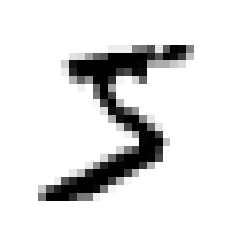

In [5]:
some_digit = X_train[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

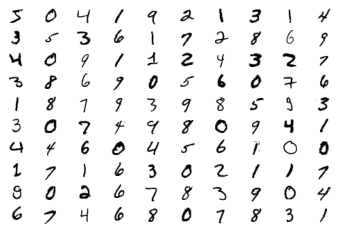

In [6]:
rows, cols = 10, 10
fig, axs = plt.subplots(rows, cols)
for i, digit in enumerate(X_train[:rows*cols]):
    digit_image = digit.reshape(28, 28)
    row = i // rows
    col = i % rows
    axs[row, col].imshow(digit_image, cmap="binary")
    axs[row, col].axis("off")
plt.show() 

In [7]:
y[0]

'5'

### Clean the data

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
cat_encoder = OneHotEncoder()
y_train_one_hot = cat_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = cat_encoder.transform(y_test.reshape(-1, 1))
print(y_train_one_hot[0].toarray())
print(y_test_one_hot[0].toarray())

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


### Shortlist promising models

model KNeighborsClassifier() accuracy 0.9046 precision 0.905469031517376, recall 0.9033156901190941 f1 0.9034544818569732
model SVC(gamma='auto') accuracy 0.9302 precision 0.9305988093901909, recall 0.9296190889868893 f1 0.92981405782456


/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


model SGDClassifier() accuracy 0.8946 precision 0.894369682782634, recall 0.8935366626616593 f1 0.893628986959228


/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


model SGDClassifier(loss='log') accuracy 0.894 precision 0.8936872350717442, recall 0.8929473879138236 f1 0.8930357646309355
model RandomForestClassifier() accuracy 0.942 precision 0.9415828200733797, recall 0.9415267476914646 f1 0.9415079744611117


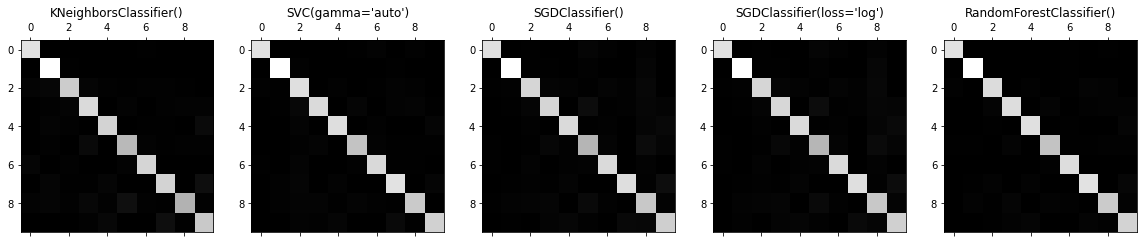

In [113]:

idx = np.random.choice(np.arange(len(y_train)), 10000, replace=False)
X_train_sample = X_train_scaled[idx, :]
y_train_sample = y_train[idx]

models = [
    KNeighborsClassifier(), 
    SVC(gamma='auto'), 
    SGDClassifier(), 
    SGDClassifier(loss="log"),
    RandomForestClassifier(), 
]

fig, axs = plt.subplots(1, len(models), figsize=(20, 8))
for i, model in enumerate(models):
    y_train_pred = cross_val_predict(model, X_train_sample, y_train_sample, cv=3)
    conf_mx = confusion_matrix(y_train_sample, y_train_pred)
    accuracy = accuracy_score(y_train_sample, y_train_pred)
    precision = precision_score(y_train_sample, y_train_pred, average="macro")
    recall = recall_score(y_train_sample, y_train_pred, average="macro")
    f1 = f1_score(y_train_sample, y_train_pred, average="macro")
    print(f"model {model} accuracy {accuracy} precision {precision}, recall {recall} f1 {f1}")
    axs[i].matshow(conf_mx, cmap=plt.cm.gray)
    axs[i].set_title(str(model))
plt.show()

In [108]:
param_distribs = {
    "n_neighbors": list(range(1, 10)),
    "weights": ["uniform", "distance"],
    "leaf_size": list(range(20, 40)),
    "p": [1, 2],
}

knc = KNeighborsClassifier()
rnd_search = RandomizedSearchCV(
    knc, 
    param_distributions=param_distribs,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
search = rnd_search.fit(X_train_scaled, y_train)
print(f"best estimator {search.best_estimator_}\nbest score {search.best_score_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..leaf_size=28, n_neighbors=1, p=2, weights=uniform; total time= 1.5min
[CV] END ..leaf_size=28, n_neighbors=1, p=2, weights=uniform; total time= 1.5min
[CV] END ..leaf_size=21, n_neighbors=5, p=2, weights=uniform; total time= 1.5min
[CV] END ..leaf_size=21, n_neighbors=5, p=2, weights=uniform; total time= 1.8min
[CV] END ..leaf_size=25, n_neighbors=5, p=2, weights=uniform; total time= 1.5min
[CV] END .leaf_size=32, n_neighbors=6, p=1, weights=distance; total time=24.3min
[CV] END .leaf_size=21, n_neighbors=8, p=1, weights=distance; total time=22.9min
[CV] END ..leaf_size=28, n_neighbors=2, p=1, weights=uniform; total time=22.0min
[CV] END ..leaf_size=32, n_neighbors=5, p=1, weights=uniform; total time=23.5min
[CV] END ..leaf_size=31, n_neighbors=9, p=2, weights=uniform; total time= 1.5min
[CV] END ..leaf_size=29, n_neighbors=2, p=1, weights=uniform; total time=22.5min
[CV] END .leaf_size=27, n_neighbors=2, p=2, wei

In [112]:
print(f"best estimator {search.best_estimator_}\nbest score {search.best_score_}")

best estimator KNeighborsClassifier(leaf_size=32, n_neighbors=6, p=1, weights='distance')
best score 0.9600166666666666


In [10]:
def augment_with_translations(X, y):
    augmented = []
    image_rows = 28
    image_cols = 28
    X_reshaped = X.reshape((X.shape[0], image_rows, image_rows))
    for row_shift, col_shift in ((-1, 0), (0, -1), (1, 0), (0, 1)):
        row_min = max(0, row_shift)
        row_max = min(image_rows, image_rows + row_shift)
        col_min = max(0, col_shift)
        col_max = min(image_cols, image_cols + col_shift)
        X_augmented = np.zeros(X_reshaped.shape)
        nrs = -1 * row_shift
        ncs = -1 * col_shift
        print(f"row_min {row_min} row_max {row_max}, col_min {col_min}, col_max {col_max}")
        print(f"row_min+nrs {row_min+nrs} row_max+nrs {row_max+nrs}, col_min+ncs {col_min+ncs}, col_max+ncs {col_max+ncs}")
        X_augmented[:, row_min:row_max, col_min:col_max] = X_reshaped[:, row_min+nrs: row_max+nrs, col_min+ncs:col_max+ncs]
        augmented.append(X_augmented.reshape(X.shape))
    return np.concatenate([X] + augmented), np.concatenate([y for _ in range(5)])
        
            
        

In [11]:
X_train_augmented, y_train_augmented = augment_with_translations(X_train, y_train)
idx = np.random.permutation(len(X_train_augmented))
X_train_augmented, y_train_augmented = X_train_augmented[idx], y_train_augmented[idx]

row_min 0 row_max 27, col_min 0, col_max 28
row_min+nrs 1 row_max+nrs 28, col_min+ncs 0, col_max+ncs 28
row_min 0 row_max 28, col_min 0, col_max 27
row_min+nrs 0 row_max+nrs 28, col_min+ncs 1, col_max+ncs 28
row_min 1 row_max 28, col_min 0, col_max 28
row_min+nrs 0 row_max+nrs 27, col_min+ncs 0, col_max+ncs 28
row_min 0 row_max 28, col_min 1, col_max 28
row_min+nrs 0 row_max+nrs 28, col_min+ncs 0, col_max+ncs 27


In [13]:
knc = KNeighborsClassifier(n_neighbors=4, weights='distance')
knc.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [14]:
y_pred = knc.predict(X_test)

In [17]:
accuracy_score(y_test, y_pred)

0.9763